In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
import sys

path0 = 'D:/SAWS_code'
path = path0 + '/real_nurse_staffing'
sys.path.append(path0)

from read_data import read_ED
from environments import real_newsvendor_env
from algorithms import SAWS_online, MA

In [2]:
# read data
syndromes = ['Asthma', 'Diarrhea', 'ILI', 'Respiratory', 'Vomiting']
boroughs = ['Bronx', 'Brooklyn', 'Citywide', 'Manhattan', 'Queens', 'Staten Island']
groups = ['Ages 0-4 years', 'Ages 18-64 years', 'Ages 5-17 years', 'Ages 65+ years', 'All age groups']

syndrome = 'Vomiting'
borough = 'Citywide'
group = 'All age groups'
year_start = 2019
year_end = 2023

counts, data = read_ED(path, syndrome, borough, group, year_start, year_end)
init = 6   # adjust the beginning date so that the first day is Monday
batches = [[math.ceil(sum(counts[init+7*k : init+7*(k+1)]) / 3)] for k in range(len(counts) // 7)]

data

,Data note 1,Ind1Name,Dim1Name,Dim1Value,Dim2Name,Dim2Value,Date,Select Metric,Count,year
94006,-Syndrome data are inherently non-specific and...,Vomiting,Citywide,Citywide,Age Group,All age groups,1/1/2019,Count,477,2019
94007,-Syndrome data are inherently non-specific and...,Vomiting,Citywide,Citywide,Age Group,All age groups,1/2/2019,Count,450,2019
94008,-Syndrome data are inherently non-specific and...,Vomiting,Citywide,Citywide,Age Group,All age groups,1/3/2019,Count,464,2019
94009,-Syndrome data are inherently non-specific and...,Vomiting,Citywide,Citywide,Age Group,All age groups,1/4/2019,Count,448,2019
94010,-Syndrome data are inherently non-specific and...,Vomiting,Citywide,Citywide,Age Group,All age groups,1/5/2019,Count,470,2019
...,...,...,...,...,...,...,...,...,...,...
95820,-Syndrome data are inherently non-specific and...,Vomiting,Citywide,Citywide,Age Group,All age groups,12/27/2023,Count,477,2023
95821,-Syndrome data are inherently non-specific and...,Vomiting,Citywide,Citywide,Age Group,All age groups,12/28/2023,Count,420,2023
95822,-Syndrome data are inherently non-specific and...,Vomiting,Citywide,Citywide,Age Group,All age groups,12/29/2023,Count,424,2023
95823,-Syndrome data are inherently non-specific and...,Vomiting,Citywide,Citywide,Age Group,All age groups,12/30/2023,Count,367,2023


In [3]:
# problem parameters
d = 1
N = len(batches)
r = 0.7

# compute per-period loss
def newsvenor_loss(forecast, actual, r):
    return np.mean([r * max(actual[t]-forecast[t], 0) + (1-r) * max(forecast[t]-actual[t], 0) for t in range(len(actual))])

In [4]:
##### SAWS #####

# initialize environment
env = real_newsvendor_env(N, batches, r)
loss = env.get_loss()
solver = env.get_solver()

# run SAWS
param = {'B':1, 'tau':5, 'alpha':0.1, 'geo_wind':True, 'reuse':False, 'compute_reg':False}
dcsn_list_SAWS, wind_list, _ = SAWS_online(env, loss, param, np.zeros(d), solver)

# record decisions
forecast_SAWS = dcsn_list_SAWS[:-1]
forecast_SAWS[0] = forecast_SAWS[0][0]

# compute per-period loss
actual = [batches[t+1][0] for t in range(len(batches)-1)]
SAWS_avgreg = newsvenor_loss(forecast_SAWS, actual, r)

# record window sizes
wind = np.array(wind_list)
right = np.array([i + 1 for i in range(N)])
left = right - wind
SAWS_windows = (left, right)

In [5]:
##### MA #####

MA_avgreg = dict()   # stores per-period losses of different fixed-window benchmarks
MA_dcsns = dict()   # stores decisions of different fixed-window benchmarks
wind_cand = [1, 2, 4, 26, 52, 104, 208]   # fixed window sizes

for wind in wind_cand:
    
    # initialize environment
    env = real_newsvendor_env(N, batches, r)
    loss = env.get_loss()
    solver = env.get_solver()

    # run Moving Average
    param = {'B':1, 'wind':wind, 'compute_reg':False}
    dcsn_list_MA, _ = MA(env, param, np.zeros(d), solver)

    # record decisions
    forecast_MA = dcsn_list_MA[:-1]
    forecast_MA[0] = forecast_MA[0][0]
    MA_dcsns[wind] = forecast_MA
    
    # compute per-period loss
    actual = [batches[t+1][0] for t in range(len(batches)-1)]
    MA_avgreg[wind] = newsvenor_loss(forecast_MA, actual, r)

In [6]:
SAWS_avgreg

24.226356589147287

In [7]:
MA_avgreg

{1: 25.07790697674419,
 2: 31.068217054263567,
 4: 29.86782945736434,
 26: 58.12403100775194,
 52: 59.23720930232558,
 104: 68.06937984496125,
 208: 65.25038759689923}

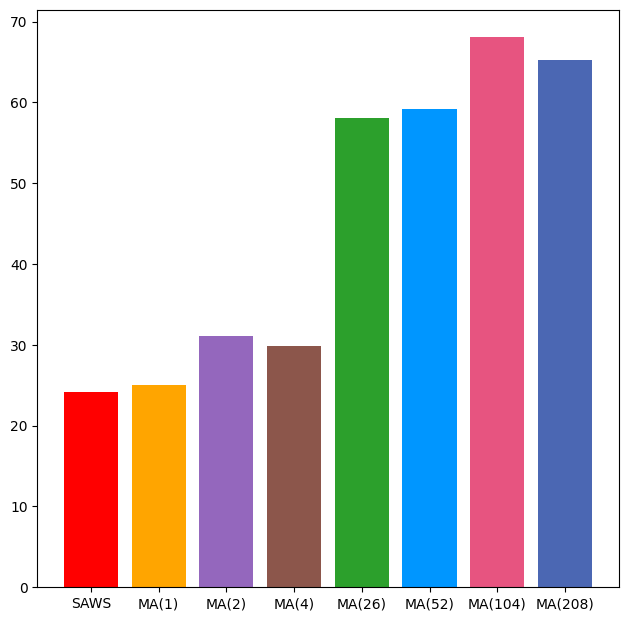

In [8]:
# plot per-period loss
colors = ['r', '#FFA500', 'tab:purple', 'tab:brown', 'tab:green', '#0096FF', '#E75480', '#4B67B3']
methods = ['SAWS'] + ['MA(' + str(wind) + ')' for wind in wind_cand]

fig, ax = plt.subplots(1, 1, figsize = (7.5, 7.5))
ax.bar(range(len(methods)), [SAWS_avgreg] + [MA_avgreg[k] for k in wind_cand], color=colors, width = 0.8)
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods)

plt.savefig('figures/bar_{}.pdf'.format(syndrome))

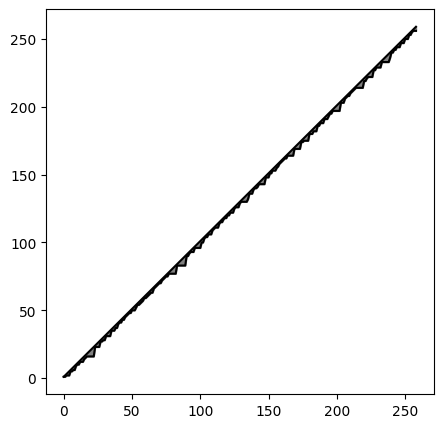

In [9]:
# plot selected windows of SAWS
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
plt.plot(range(N), SAWS_windows[0], color='black')
plt.plot(range(N), SAWS_windows[1], color='black')
plt.fill_between(range(N), SAWS_windows[0], SAWS_windows[1], color='grey')
plt.savefig('figures/windows_{}.pdf'.format(syndrome))

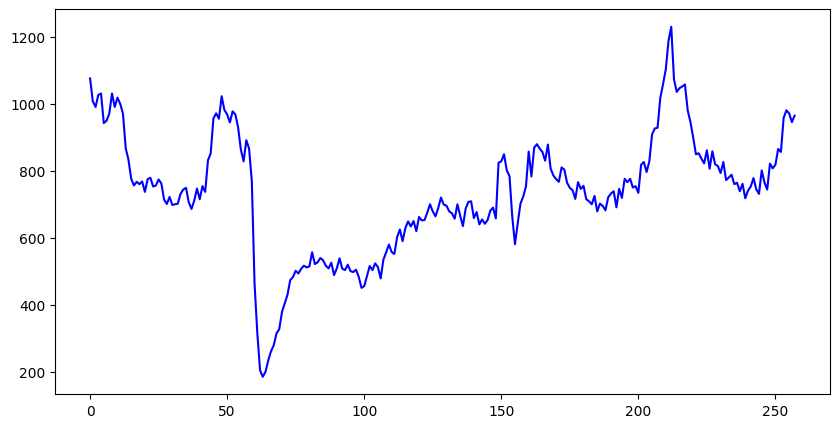

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
plt.plot(range(len(actual)), actual, color='blue')
plt.savefig('figures/pattern_{}.pdf'.format(syndrome))